# Бинарная классификация сетевого трафика: безопасный и вирусный.

Требуется определить является ли сетевое взаимодействие опасным/безопасным по большому числу признаков трафика. 

## Подключение модулей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline              
import pandas as pd
import seaborn as sns
import sklearn

## Загрузка данных

In [2]:
url = './data/dataset.csv'
data = pd.read_csv(url, sep=',', header=0, engine='python')
data.shape

(177482, 85)

## Подготовка данных

### Пропущенные 

In [3]:
data.isna().sum().sum() # их нет

0

### Обработка текстовых данных

In [4]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
categorical_columns

['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp', 'Class']

In [5]:
from sklearn import preprocessing
data_describe = data.describe(include = [object])
number = preprocessing.LabelEncoder()
data["FlowID"] = number.fit_transform(data["FlowID"])
data["SourceIP"] = number.fit_transform(data["SourceIP"])
data["DestinationIP"] = number.fit_transform(data["DestinationIP"])
data["Timestamp"] = number.fit_transform(data["Timestamp"])

In [6]:
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]

In [7]:
data['Class'].unique()

array(['Trojan', 'Benign'], dtype=object)

In [8]:
data.at[data['Class'] == 'Trojan', 'Class'] = 1
data.at[data['Class'] == 'Benign', 'Class'] = 0
data['Class'].describe()

count     177482
unique         2
top            1
freq       90683
Name: Class, dtype: int64

### Нормализация числовых данных

In [9]:
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']
len(numerical_columns)

84

In [10]:
data_numerical = data[numerical_columns].astype('float32')

In [11]:
data_numerical.std(axis = 0)

FlowID             2.614904e+04
SourceIP           3.255239e+02
SourcePort         1.843583e+04
DestinationIP      9.059336e+02
DestinationPort    1.515598e+04
                       ...     
ActiveMin          7.506802e+05
IdleMean           1.542957e+07
IdleStd            3.246955e+06
IdleMax            1.627581e+07
IdleMin            1.504980e+07
Length: 84, dtype: float32

In [12]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical = data_numerical.fillna(0.0)

### Соединение всех данных

In [13]:
data = pd.concat((data_numerical, data[binary_columns]), axis = 1)
data.shape

(177482, 85)

In [14]:
data.head()

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Class
73217,-0.254680,-0.301850,0.615199,-0.551040,-0.374989,-0.505653,1.285073,-0.038628,-0.092527,-0.055528,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
72089,0.846469,-0.301850,0.571479,0.048341,-0.351038,1.916987,1.531425,-0.494133,-0.025086,-0.027333,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
96676,-1.665593,-0.301850,-0.047966,-0.931863,-0.376771,1.916987,1.765842,-0.460738,-0.193688,-0.083723,...,0.631080,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,0
42891,-1.619663,-0.301850,0.147468,-0.931863,-0.376771,1.916987,0.755896,-0.492732,-0.193688,-0.083723,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
169326,-1.224047,-0.307994,0.310249,-0.696746,-0.351038,-0.505653,-0.346225,2.344973,0.177238,0.000862,...,0.631080,0.231390,-0.082902,0.182972,0.261303,3.614245,-0.123948,3.404611,3.725784,0


## Разбиение данных для обучения и тестов

In [15]:
X = data.drop('Class', axis = 1)
y = data['Class']

In [16]:
X = X.to_numpy()
y = np.array(y, dtype='int')

In [17]:
X.shape

(177482, 84)

In [18]:
y.shape

(177482,)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

88741 88741


## Обучение полносвязной нейронной сети

### 1 скрытый слой

In [20]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (50,),
                          solver = 'adam', 
                          activation = 'logistic',
                          max_iter=2000,
                          random_state = 42,
                          verbose=1,
                          tol=1e-3)

In [21]:
%%time
mlp_model.fit(X_train, y_train)

Iteration 1, loss = 0.53665937
Iteration 2, loss = 0.34765376
Iteration 3, loss = 0.32475806
Iteration 4, loss = 0.30406588
Iteration 5, loss = 0.28196065
Iteration 6, loss = 0.26033593
Iteration 7, loss = 0.23888107
Iteration 8, loss = 0.21589864
Iteration 9, loss = 0.19013722
Iteration 10, loss = 0.16461450
Iteration 11, loss = 0.14430994
Iteration 12, loss = 0.12896321
Iteration 13, loss = 0.11762729
Iteration 14, loss = 0.10905886
Iteration 15, loss = 0.10227481
Iteration 16, loss = 0.09672963
Iteration 17, loss = 0.09202626
Iteration 18, loss = 0.08817546
Iteration 19, loss = 0.08487459
Iteration 20, loss = 0.08191073
Iteration 21, loss = 0.07922264
Iteration 22, loss = 0.07701203
Iteration 23, loss = 0.07472136
Iteration 24, loss = 0.07264819
Iteration 25, loss = 0.07106855
Iteration 26, loss = 0.06933130
Iteration 27, loss = 0.06776645
Iteration 28, loss = 0.06647610
Iteration 29, loss = 0.06508999
Iteration 30, loss = 0.06390572
Iteration 31, loss = 0.06281929
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=(50,), max_iter=2000,
              random_state=42, tol=0.001, verbose=1)

**Ошибки на тестовой выборке**

In [22]:
y_test_predict = mlp_model.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.01401832298486607

**Ошибки на тренировочной выборке**

In [23]:
y_train_predict = mlp_model.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.011730767063702234

### 2 скрытых слоя

In [24]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (50, 12),
                          solver = 'adam', 
                          activation = 'logistic',
                          max_iter=2000,
                          random_state = 42,
                          verbose=1,
                          tol=1e-3)

In [25]:
%%time
mlp_model.fit(X_train, y_train)

Iteration 1, loss = 0.60788437
Iteration 2, loss = 0.26803039
Iteration 3, loss = 0.21652467
Iteration 4, loss = 0.20664578
Iteration 5, loss = 0.20122035
Iteration 6, loss = 0.19717699
Iteration 7, loss = 0.19365643
Iteration 8, loss = 0.19090295
Iteration 9, loss = 0.18859593
Iteration 10, loss = 0.18652124
Iteration 11, loss = 0.18473191
Iteration 12, loss = 0.18337481
Iteration 13, loss = 0.18182003
Iteration 14, loss = 0.18075498
Iteration 15, loss = 0.17961836
Iteration 16, loss = 0.17853265
Iteration 17, loss = 0.17554647
Iteration 18, loss = 0.16328090
Iteration 19, loss = 0.14877744
Iteration 20, loss = 0.13382857
Iteration 21, loss = 0.12031965
Iteration 22, loss = 0.10896604
Iteration 23, loss = 0.10012631
Iteration 24, loss = 0.09254884
Iteration 25, loss = 0.08608414
Iteration 26, loss = 0.08070256
Iteration 27, loss = 0.07588817
Iteration 28, loss = 0.07207295
Iteration 29, loss = 0.06871701
Iteration 30, loss = 0.06531734
Iteration 31, loss = 0.06219880
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 12), max_iter=2000,
              random_state=42, tol=0.001, verbose=1)

**Ошибки на тестовой выборке**

In [26]:
y_test_predict = mlp_model.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.011606810831520943

**Ошибки на тренировочной выборке**

In [27]:
y_train_predict = mlp_model.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.009950304819643683

Сильного прироста от второго слоя нет

### Подбор параметра альфа (1 скрытый слой)

In [28]:
from sklearn.metrics import accuracy_score
import tqdm
alpha_arr = np.logspace(-5, 1, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in tqdm.tqdm_notebook(alpha_arr):
    mlp_model = MLPClassifier(alpha=alpha,
                              hidden_layer_sizes = (50,),
                              solver = 'adam', 
                              activation = 'logistic',
                              max_iter=2000,
                              random_state = 42,
                              #verbose=1,
                              tol=1e-3)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

C:\Users\veter\AppData\Local\Temp/ipykernel_1980/749961129.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for alpha in tqdm.tqdm_notebook(alpha_arr):


  0%|          | 0/21 [00:00<?, ?it/s]

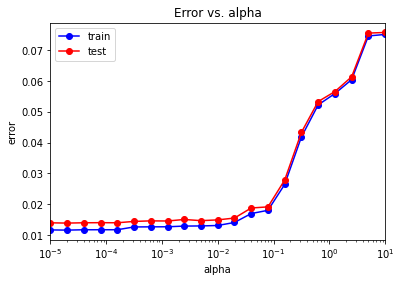

In [29]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

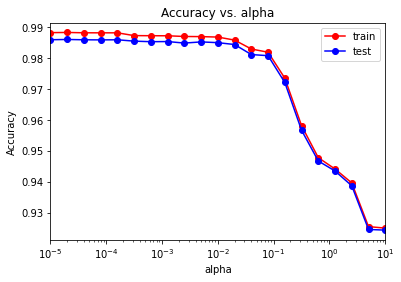

In [30]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

In [32]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.011651885825041413 0.013928172997825132


In [33]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[1.99526231e-05]


In [34]:
alpha_opt = alpha_opt[0]

### Подбор числа нейронов (1 скрытый слой)

In [35]:
from sklearn.metrics import accuracy_score
import tqdm
neurons_count_arr = np.array([i for i in range(2, 100+1)])
test_err = []
train_err = []
train_acc = []
test_acc = []

for neurons_count in tqdm.tqdm_notebook(neurons_count_arr):
    mlp_model = MLPClassifier(alpha=alpha_opt,
                              hidden_layer_sizes = (neurons_count,),
                              solver = 'adam', 
                              activation = 'logistic',
                              max_iter=2000,
                              random_state = 42,
                              #verbose=1,
                              tol=1e-3)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

C:\Users\veter\AppData\Local\Temp/ipykernel_1980/1571838247.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for neurons_count in tqdm.tqdm_notebook(neurons_count_arr):


  0%|          | 0/99 [00:00<?, ?it/s]

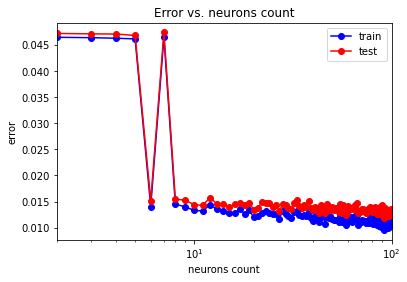

In [43]:
plt.semilogx(neurons_count_arr, train_err, 'b-o', label = 'train')
plt.semilogx(neurons_count_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neurons_count_arr), np.max(neurons_count_arr)])
plt.title('Error vs. neurons count')
plt.xlabel('neurons count')
plt.ylabel('error')
plt.legend()

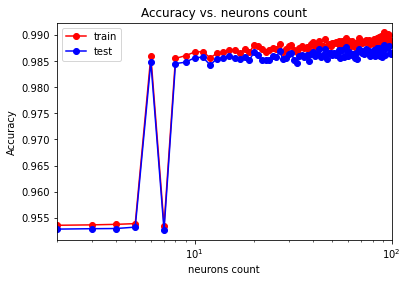

In [52]:
plt.semilogx(neurons_count_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(neurons_count_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(neurons_count_arr), np.max(neurons_count_arr)])
plt.title('Accuracy vs. neurons count')
plt.xlabel('neurons count')
plt.ylabel('Accuracy')
plt.legend()

In [57]:
# возьмем первый пик по Accuracy, т.к. разница > 10 не такая большая, а время обучение существенно меньше
test_acc[:11]

[0.9528402880292086,
 0.9529191692678695,
 0.9529529755130097,
 0.9532234254741326,
 0.9847984584352216,
 0.9526487193067465,
 0.9844942022289584,
 0.9847533834417012,
 0.9855985395702099,
 0.9857112270540112,
 0.9842237522678356]

In [66]:
id_max = 4
neurons_count_opt = neurons_count_arr[id_max]
neurons_count_opt

6

### Финальное обучение с оптимальными параметрами (по точности и времени)

In [71]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (neurons_count_opt,),
                          alpha=alpha_opt,
                          solver = 'adam', 
                          activation = 'logistic',
                          max_iter=2000,
                          random_state = 42,
                          #verbose=1,
                          tol=1e-3)

In [72]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 8.56 s


MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(6,),
              max_iter=2000, random_state=42, tol=0.001)

**Ошибки на тестовой выборке**

In [73]:
y_test_predict = mlp_model.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.014638104145772528

**Ошибки на тренировочной выборке**

In [74]:
y_train_predict = mlp_model.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.013635185539942078

In [76]:
1-err_test, 1-err_train

(0.9853618958542275, 0.986364814460058)

**Матрица рассогласования:**

In [77]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[39378  2260]
 [ 4017 43086]]


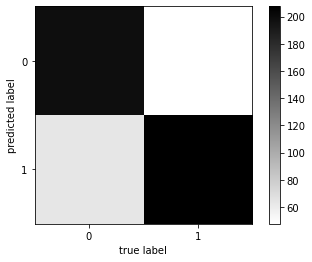

In [80]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     43404
           1       0.99      0.98      0.99     45337

    accuracy                           0.99     88741
   macro avg       0.99      0.99      0.99     88741
weighted avg       0.99      0.99      0.99     88741

